In [42]:
import re
import os
import csv
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from natsort import natsorted, ns
from scipy.fftpack import fft
from matplotlib import gridspec
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter
from matplotlib import rcParams

rcParams['font.family'] = 'Times New Roman'
rcParams['font.weight'] = 100
plt.rcParams['xtick.labelsize']=16
plt.rcParams['ytick.labelsize']=16
%matplotlib inline


def ReadBucket(file):
    f = open(file, "r")
    line = f.readline()
    i_num = 1
    buckets = []
    while line:
        if line.startswith("BucketName"):
            line = f.readline()
            b_num = 1
            pivots = []
            sizes  = []
            while line.startswith("/mnt/nvm"):
                data = line.strip().split();
                pivots.append(int(re.findall(r"\d{16}",data[0])[0])) # pivots
                sizes.append(float(data[1])/1024/1024) # size in MB
                line = f.readline()
            buckets.append([pivots, sizes])
        line = f.readline()
    return buckets

df2 = pd.DataFrame(columns = []) 
def ReadFile(name, file):
    wip = pd.DataFrame(columns = ['time', 'thread', 'count', 'speed']) 
    wip_bucket = pd.DataFrame(columns = ['Bucket']) 
    wip_wa = pd.DataFrame(columns = ['Write Amplification']) 
    with open(file) as origin_file:
        for line in origin_file:
            if line.startswith("20"):
                data = line.strip().split()
                data = [data[i] for i in (0,3,4,7)]
                wip.loc[len(wip)] = data
            if line.startswith("BucketCount"):
                data = line.strip().split();
                wip_bucket.loc[len(wip_bucket)] = float(data[1])  
            if line.startswith("WriteAmplification"):
                data = line.strip().split();
                wip_wa.loc[len(wip_wa)] = float(data[1])  
    df2[name] = wip['speed'].apply(extract_current)
    df2[name] = df2[name] / 1000.0 / 1000.0
    df2[name + '_bucket'] = wip_bucket["Bucket"] / 1000
    df2[name + '_wa'] = wip_wa["Write Amplification"]
    

def extract_current(speeds):
    result = re.findall(r"[-+]?\d*\.\d+|\d+", speeds)
    return float(result[0])

def MyPlot(title, name, ax_up, ax_down, wa_pos, is_left_y=False, is_right_y=False, x_title="(a)"):
    def billions(x, pos):
        'The two args are the value and tick position'
        return '%1.0f' % (x/10)
    def ytickformat(x, pos):
        return '%1.1f' % (x)
    def ytickformat2(x, pos):
        return '%1.1f' % (x/1000.0)
    lw=3
    formatter = FuncFormatter(billions)
    formattery = FuncFormatter(ytickformat)
    df2[name].plot(ax=ax_up, fontsize=20, color='darkgreen', linewidth=lw)
    ax_up.set_title(title, fontsize=24)
    ax_up.yaxis.grid(linewidth=1, linestyle='--')
    ax_up.set_axisbelow(True)
    ax_up.yaxis.set_major_formatter(formattery)
    ax_up.tick_params(axis="y", labelsize=16)
    major_ticks = np.arange(0, 1, 0.2)
    ax_up.set_yticks(major_ticks)
    ax_up.set_ylim([0, 1.])
    ax_up.set_xlim([-1,81])
    ax_up.set_xticks([])
    ax_up.spines["top"].set_visible(False) 
    ax_up.yaxis.set_label_coords(0.06, 1)
    ax_up.tick_params(axis='y', labelcolor='darkgreen')
    
    axt = ax_up.twinx();
    axt.spines["top"].set_visible(False) 
    df2[name + '_bucket'].plot(ax=axt, dashes=[2, 2], color='k', markersize=8, linewidth=lw)
    axt.set_ylim([0, 2])
    start, end = axt.get_ylim()
    axt.yaxis.set_ticks(np.arange(start, end, 0.4))
    axt.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.1f k'))
    axt.set_xlim([-1,81])
    axt.legend(["Number of Buckets"], loc="lower right", fontsize=24, edgecolor='w')
    df2[name + '_wa'].plot(ax=ax_down, linewidth=lw)
#     ax_down.plot([wa_pos], [df2[name + '_wa'][wa_pos]], color='steelblue', marker='o')
#     ax_down.text(wa_pos - 4, 2.7, df2[name + '_wa'][wa_pos], color='steelblue', fontsize=16)
    ax_down.yaxis.grid(linewidth=1, linestyle='--')
    ax_down.set_axisbelow(True)
    ax_down.spines["top"].set_visible(False) 
    ax_down.tick_params(axis='y', labelcolor='steelblue')
    ax_down.set_xlim([-1,81])
    ax_down.xaxis.set_major_formatter(formatter)
    ax_down.set_ylim([2.5, 3.6])
    
    if(not is_left_y):
        ax_up.set_yticklabels([])
        ax_down.set_yticklabels([])
    else:
        ax_up.set_ylabel( 'Mops/s', fontsize=20, color='darkgreen', va='bottom', rotation=0)
        ax_up.yaxis.set_label_coords(0,1.02)
    if(not is_right_y):
        axt.set_yticklabels([])
    else:
        axt.set_ylabel( 'Bucket #', fontsize=20, color='k', va='bottom', rotation=0)
        axt.yaxis.set_label_coords(1,1.02)
    # set legend font color same as the line color
    leg = ax_down.legend(["Write Amplification"], loc="lower right", fontsize=24, edgecolor='w',framealpha=0)
    for line, text in zip(leg.get_lines(), leg.get_texts()):
        text.set_color(line.get_color())
    ax_down.set_xlabel(x_title, fontsize=24)
    ax_up.tick_params(axis='both', which='major', labelsize=24)
    ax_down.tick_params(axis='both', which='major', labelsize=24)
    ax_down.xaxis.set_major_locator(ticker.MultipleLocator(10))

In [44]:
buckets = ReadBucket("kv8B_nvm_hugepage_changeDistribution3B5B.log")
ReadFile("wip_3","kv8B_nvm_hugepage_changeDistribution3B5B.log")

# for i in range(7):
#     fig = plt.figure(figsize=(10, 2)) 
#     gs = gridspec.GridSpec(2, 1) 
#     gs.update(wspace=0.1, hspace=0.) # set the spacing between axes. 
#     ax = [0,0]
#     ax[0] = plt.subplot(gs[0,0])
#     ax[1] = plt.subplot(gs[1,0])
#     ax[0].hist(buckets[i][0], bins=100, alpha=0.5)
#     plt.plot(buckets[i][0], buckets[i][1], 'k-')

/Users/xingshengzhao/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


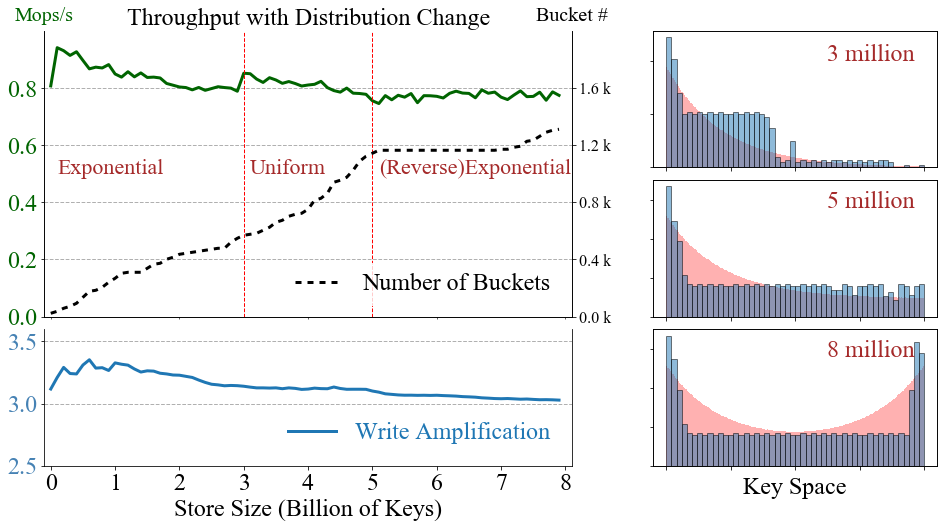

In [50]:
fig = plt.figure(figsize=(16, 8)) 
gs = gridspec.GridSpec(6, 8) 
gs.update(wspace=2, hspace=0.2) # set the spacing between axes. 
ax = [0,0,0,0,0]
ax[0] = plt.subplot(gs[0:4,0:5])
ax[1] = plt.subplot(gs[4:6,0:5])
ax[2] = plt.subplot(gs[0:2,5:8])
ax[3] = plt.subplot(gs[2:4,5:8])
ax[4] = plt.subplot(gs[4:6,5:8])

MyPlot("Throughput with Distribution Change",'wip_3', ax[0], ax[1], 0, True, True, "Store Size (Billion of Keys)")

ax[2].hist(buckets[2][0], bins=50, alpha=0.5, edgecolor='black', linewidth=1)
ax2 = ax[2].twinx()
cdf_exp = pd.read_csv('CDF/exponential_50M.txt',header=None)
cdf_exp.drop(cdf_exp.columns[1], axis=1, inplace=True)
exp_hist = cdf_exp[0].tolist()
ax2.hist(exp_hist, bins=200, alpha=0.3, color='red')
ax[2].set_xticklabels([])
ax[2].set_yticklabels([])
ax2.set_yticks([])
ax[2].set_zorder(10)
ax[2].patch.set_visible(False)
ys, ym = ax2.get_ylim()
ax2.set_ylim([ys, 1.3*ym])

ax[3].hist(buckets[4][0], bins=50, alpha=0.5, edgecolor='black', linewidth=1)
ax3 = ax[3].twinx()
cdf_exp_uni = pd.read_csv('CDF/uniform_exponential_50M.txt',header=None)
cdf_exp_uni.drop(cdf_exp_uni.columns[1], axis=1, inplace=True)
exp_uni_hist = cdf_exp_uni[0].tolist()
ax3.hist(exp_uni_hist, bins=200, alpha=0.3, color='red')
ax[3].set_xticklabels([])
ax[3].set_yticklabels([])
ax3.set_yticks([])
ax[3].set_zorder(10)
ax[3].patch.set_visible(False)
ys, ym = ax3.get_ylim()
ax3.set_ylim([ys, 1.3*ym])

ax[4].hist(buckets[8][0], bins=50, alpha=0.5, edgecolor='black', linewidth=1)
ax4 = ax[4].twinx()
cdf_exp_uni_exp = pd.read_csv('CDF/exponential_uniform_exponential_50M.txt',header=None)
cdf_exp_uni_exp.drop(cdf_exp_uni_exp.columns[1], axis=1, inplace=True)
exp_uni_exp_hist = cdf_exp_uni_exp[0].tolist()
ax4.hist(exp_uni_exp_hist, bins=200, alpha=0.3, color='red')
ax[4].set_xticklabels([])
ax[4].set_yticklabels([])
ax4.set_yticks([])
ax[4].set_zorder(10)
ax[4].patch.set_visible(False)
ys, ym = ax4.get_ylim()
ax4.set_ylim([ys, 1.3*ym])

style = dict(size=14, color='brown')
ax[0].text(1, 0.50, "Exponential", **style, fontsize=22)
ax[0].axvline(30, linestyle='--', color='red', linewidth=1) # vertical lines
ax[0].text(31, 0.50, "Uniform", **style, fontsize=22)
ax[0].axvline(50, linestyle='--', color='red', linewidth=1) # vertical lines
ax[0].text(51, 0.50, "(Reverse)Exponential", **style, fontsize=22)

ax[2].text(5e9, 40, "3 million", **style, fontsize=24)
ax[3].text(5e9, 70, "5 million", **style, fontsize=24)
ax[4].text(5e9, 70, "8 million", **style, fontsize=24)
# ax[2].set_title("Bucket Histogram", fontsize=24)
ax[4].set_xlabel("Key Space", fontsize=24)

fig.tight_layout()
plt.savefig("8BInsertSplit3.pdf", bbox_inches='tight')